Setup the dataset for a demonstration of transfer learning. 

+ Perform any cleaning necessary, like throwing out bad images. This will be specific to your dataset. You may discover a problem later, come back and eliminate the bad images here.
+ Select at most 5 classes. Discard the rest of the data.
+ Create a smaller subset of less 100 images per class for training and testing.
+ Figure out how the labels are provided and create a data loader to load the data.
+ If the images are separated into subdirectories, the example above works.
+ If the image information is in a CSV file, easist path is to figure out the way to separate your classes into subdirectories and use the above example.

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

In [7]:
!ls

DataLoader.ipynb	      pizza-not-pizza.zip
Image-Classification-Example  pizza_not_pizza


In [8]:
!ls pizza_not_pizza

food101_subset.py  not_pizza  pizza


### Filtering out bad images

In [10]:
num_skipped = 0
for folder_name in ("pizza", "not_pizza"):
     max_images = 100
     folder_path = os.path.join("pizza_not_pizza", folder_name)
     for image_i,fname in enumerate(os.listdir(folder_path)):
         fpath = os.path.join(folder_path, fname)
         try:
             fobj = open(fpath, "rb")
             is_jfif = b"JFIF" in fobj.peek(10)
         finally:
             fobj.close()

         if image_i > max_images or not is_jfif:
             num_skipped += 1
             # Delete corrupted image
             os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1764 images.


Selecting a subset and classes

In [11]:
import shutil
import random

# Select classes and discard extra classes
classes = ['pizza','not_pizza']

# Create directories for train and test data
train_dir = "train_data"
test_dir = "test_data"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Copy a subset of images for each class to train and test directories
for class_name in classes:
    class_dir = os.path.join("pizza_not_pizza", class_name)
    all_images = os.listdir(class_dir)
    selected_images = np.random.choice(all_images, size=min(100, len(all_images)), replace=False)
    train_images, test_images = train_test_split(selected_images, test_size=0.2, random_state=42)
    
    for image in train_images:
        src = os.path.join(class_dir, image)
        dst = os.path.join(train_dir, class_name, image)
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        shutil.copy(src, dst)
    
    for image in test_images:
        src = os.path.join(class_dir, image)
        dst = os.path.join(test_dir, class_name, image)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
        shutil.copy(src, dst)

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generators for train and test data
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

# Load test data
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')


Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


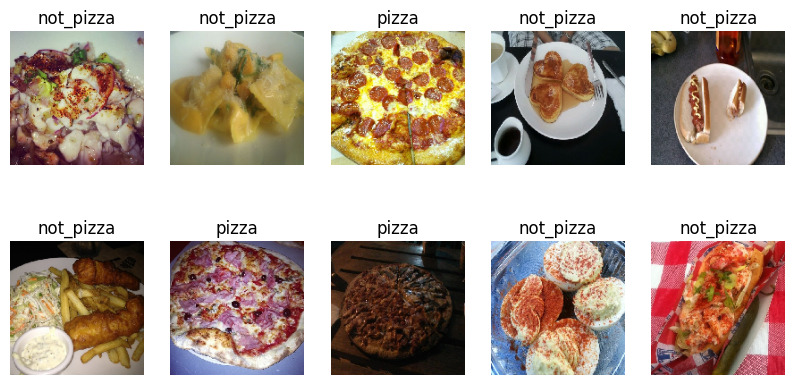

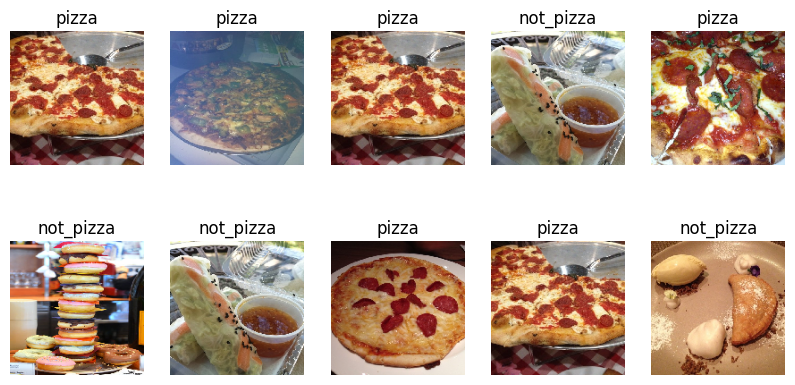

In [13]:
def visualize_images(generator, num_images=5):
    """
    Visualizes a few sample images from the data generator.
    
    Parameters:
        generator (DirectoryIterator): Data generator for loading images.
        num_images (int): Number of images to visualize for each class. Default is 5.
    """
    class_labels = {v: k for k, v in generator.class_indices.items()}
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        for j in range(2):  # Number of classes (binary)
            plt.subplot(2, num_images, i + 1 + j * num_images)
            batch = next(generator)
            image = batch[0][0]
            label = class_labels[int(batch[1][0])]
            plt.imshow(image)
            plt.title(label)
            plt.axis('off')
    plt.show()

# Visualize sample images from the training and test data
visualize_images(train_generator)
visualize_images(test_generator)

In [14]:
# dataloaders.py, will be created outside of this